In [126]:
import numpy as np
from tensorflow import keras
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import cv2
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Preprocessing and Visualization

In [127]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

#HOG feature extraction
def extract_hog(xs):
    hog_features = []
    for x in xs:
        # Convert to grayscale
        x_gray = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) / 255.0
        h_x = hog(x_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        hog_features.append(h_x)
    return np.array(hog_features)

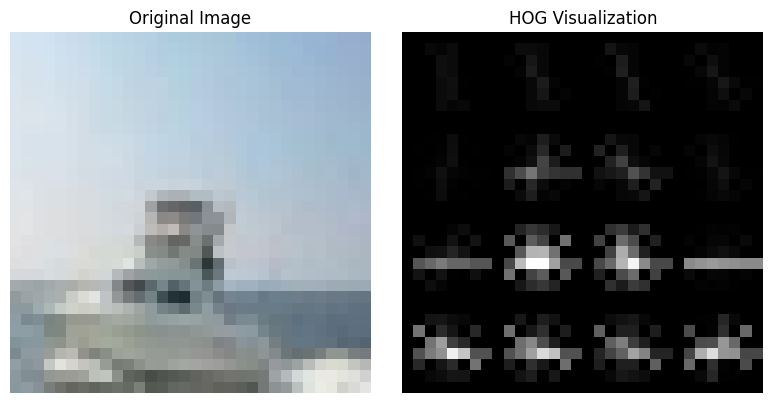

In [128]:
# Visualization: Original vs. HOG image
from skimage import exposure
example_img = x_train[100]
example_gray = cv2.cvtColor(example_img, cv2.COLOR_RGB2GRAY) / 255.0
_, hog_image = hog(example_gray, visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(example_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title("HOG Visualization")
plt.axis("off")
plt.tight_layout()
plt.show()

In [129]:
# Color histogram feature extraction
def extract_color_histogram(data, bins=8):
    color_hist_features = []
    for x in data:
        hist_r = np.histogram(x[:, :, 0], bins=bins, range=(0, 255), density=True)[0]
        hist_g = np.histogram(x[:, :, 1], bins=bins, range=(0, 255), density=True)[0]
        hist_b = np.histogram(x[:, :, 2], bins=bins, range=(0, 255), density=True)[0]
        hist = np.concatenate([hist_r, hist_g, hist_b])
        color_hist_features.append(hist)
    return np.array(color_hist_features)

In [130]:
#Extract features
x_train_hog = extract_hog(x_train)
x_test_hog = extract_hog(x_test)
x_train_color = extract_color_histogram(x_train)
x_test_color = extract_color_histogram(x_test)

#Combine features
x_train_combined = np.hstack([x_train_hog, x_train_color])
x_test_combined = np.hstack([x_test_hog, x_test_color])

#Standardize
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_combined)
x_test_scaled = scaler.transform(x_test_combined)

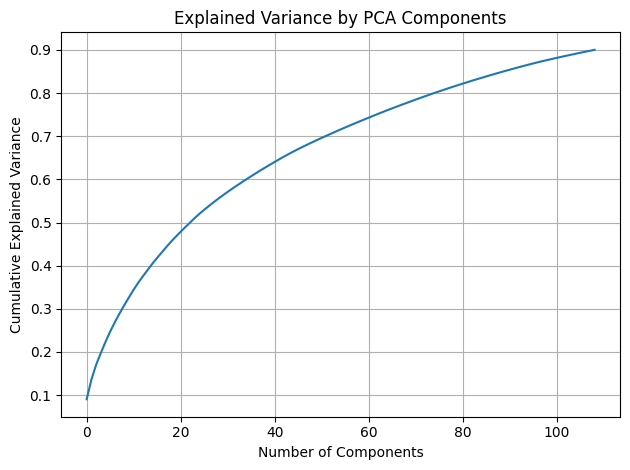

In [131]:
#PCA
pca = PCA(n_components=0.9)#keep 90% variance
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

#PCA Variance plot
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.tight_layout()
plt.show()

In [132]:
x_train_scaled.shape

(50000, 348)

In [133]:
x_train_pca.shape

(50000, 109)

# Model

In [134]:
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=10,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    n_estimators=500, 
    random_state=42,
    n_jobs=-1,
    eval_metric='merror',
)

model_xgb.fit(
    x_train_pca, y_train
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1, num_class=10, ...)

# Evaluation

In [135]:
y_pred = model_xgb.predict(x_test_pca)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.2f}")

Test Accuracy: 0.60


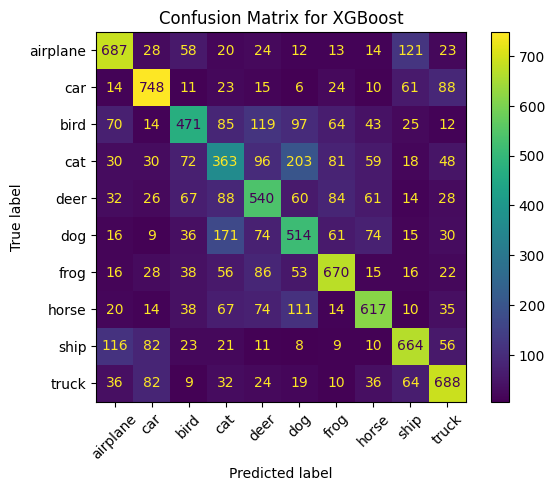

In [136]:
labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix for XGBoost")
plt.xticks(rotation=45)
plt.show()